## Подключим данные и необходимые библиотеки

In [ ]:
!pip install phik
!pip install ydata_profiling

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from ydata_profiling import ProfileReport
import phik
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import loguniform
from scipy.stats import uniform
import torch
from torch import nn
import matplotlib.pyplot as plt

In [3]:
# Загрузим данные
bank_churn = pd.read_csv('https://raw.githubusercontent.com/sergigusev/Datasets/main/bank_churn.csv')

In [ ]:
display(bank_churn)

RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0        2.0       0.00              1          1               1   
1        1.0   83807.86              1          0               1   
2        8.0  159660.80              3          1               0   
3        1.0       0.00              2          0               0   
4        2.0  125510.82              1          1               1   
...      ...        ...            ...        ...             ...   
9995     5.0       0.00              2          1               0   
9996    10.0   57369.61              1          1               1   
9997     7.0       0.00              1          0               1   
9998     3.0   75075.31              2          1               0   
9999     NaN  130142.79              1          1               0   

      EstimatedSalary  Exited  
0           101348.88       1  
1           112542.58       0  
2           113931.57       1  
3            93826.63       0  
4            79084.10       0  
...               ...     ...  
9995         96270.64       0  
9996        101699.77       0  
9997         42085.58       1  
9998         92888.52       1  
9999         38190.78       0  

[10000 rows x 14 columns]

## EDA

In [ ]:
# Поверхностно взглянем на данные с помощью профайлера
profile = ProfileReport(bank_churn, title="Clients")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
bank_churn.describe()

RowNumber    CustomerId   CreditScore           Age       Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  9091.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800     4.997690   
std     2886.89568  7.193619e+04     96.653299     10.487806     2.894723   
min        1.00000  1.556570e+07    350.000000     18.000000     0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000     2.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000     5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000     7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000    10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797   
min         0.000000       1.000000      0.00000        0.000000   
25%         0.000000       1.000000      0.00000        0.000000   
50%     97198.540000       1.000000      1.00000        1.000000   
75%    127644.240000       2.000000      1.00000        1.000000   
max    250898.090000       4.000000      1.00000        1.000000   

       EstimatedSalary        Exited  
count     10000.000000  10000.000000  
mean     100090.239881      0.203700  
std       57510.492818      0.402769  
min          11.580000      0.000000  
25%       51002.110000      0.000000  
50%      100193.915000      0.000000  
75%      149388.247500      0.000000  
max      199992.480000      1.000000

Сразу же бросаются в глаза пропуски в переменной **Tenure**

В признаках **Balance** и **EstimatedSalary** просматриваются выбросы. В целом оно интуитивно понятно в виду различности в доходах клиентов

In [ ]:
# Проверим пропущенные значения
bank_churn.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

909 значений **Tenure** пропущены. Поработаем с пропусками

In [ ]:
# Посмотрим на типы данных
bank_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Также бросаются в глаза ненужные арибуты

Атрибуты **Geography** и **Gender** имеют тип object. Поработаем с кодированием

In [4]:
# Удалим 'ненужные' столбцы
bank_churn = bank_churn.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [ ]:
# Посмотрим на баланс классов в целевой переменной
bank_churn['Exited'].value_counts(normalize=True)

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

Классы несбалансированны. Явный перекос в сторону того, что клиент продолжит пользоваться услугами банка (80%) против 20% - уйдёт из банка. Поработаем с балансом классов

In [ ]:
# Взглянем на корреляцию между признаками с помощью phik
bank_churn.drop(
    columns=['Geography', 'Gender', 'Exited']).phik_matrix(
        interval_cols=bank_churn.columns).style.background_gradient(
            cmap='coolwarm'
)


Мультиколлинеарности между признаками не замечено

## Report

In [124]:
# Создадим DataFrame для отчета и соответствующую функцию для работы с ним
report_df = pd.DataFrame(columns=[
    'Model',
    'Train_score',
    'Train_time',
    'Valid_score',
    'Valid_time'
])

def add_to_report(report_df, model_name, train_score,
                  train_time, valid_score, valid_time
):
    new_entry = pd.DataFrame({
        'Model': [model_name],
        'Train_score': [train_score],
        'Train_time': [train_time],
        'Valid_score' : [valid_score],
        'Valid_time' : [valid_time]
})
    report_df = pd.concat([report_df, new_entry], ignore_index=True)
    return report_df

## Preprocessing (Pipelines)

In [121]:
# Разделим данные на признаки и целевую переменную
X = bank_churn.drop('Exited', axis=1)
y = bank_churn['Exited']

In [122]:
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

### Pipeline

In [123]:
# Заполним пропуски в Tenure медианой
# Проведём стандартизацию признаков
# Проведём кодирование категориальных признаков Geography и Gender
preprocessor = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()),
     make_column_selector(dtype_include=np.number)),
    (make_pipeline(OneHotEncoder(drop='first', handle_unknown='error')),
     make_column_selector(dtype_include=object))
)

## Baseline: LogisticRegression

In [125]:
# Построим базовую модель
# Используем параметр class_weight='balanced' для балансировки классов

logreg_model = make_pipeline(preprocessor, LogisticRegression(
    class_weight='balanced',
    random_state=42)
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logreg_scores = cross_validate(logreg_model, X_train,
                               y_train, cv=cv,
                               scoring='recall', return_train_score=True
)

print('Mean recall Train time:', round(np.sum(logreg_scores['fit_time']), 2))
print('Mean recall Train score:', round(np.mean(logreg_scores['train_score']), 2))
print('Mean recall Valid time:', round(np.sum(logreg_scores['score_time']), 2))
print('Mean recall Valid score:', round(np.mean(logreg_scores['test_score']), 2))

Mean recall Train time: 0.21
Mean recall Train score: 0.69
Mean recall Valid time: 0.05
Mean recall Valid score: 0.68


In [126]:
# Логистическая регрессия class_weight='balanced'
report_df = add_to_report(
    report_df,
    'LogisticRegression',
    round(np.mean(logreg_scores['train_score']), 2),
    round(np.sum(logreg_scores['fit_time']), 2),
    round(np.mean(logreg_scores['test_score']), 2),
    round(np.sum(logreg_scores['score_time']), 2)
)

## Decision Tree + GridSearchCV

In [ ]:
# Построим модель дерева решений
# Используем параметр class_weight='balanced' для балансировки классов
# Подберём гипермараметры модели с пмощью GridSearch

tree_model = make_pipeline(preprocessor, DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42)
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tree_params = {
    'decisiontreeclassifier__min_samples_leaf': range(1, 15),
    'decisiontreeclassifier__max_features': [None, 'sqrt', 'log2'],
    'decisiontreeclassifier__max_depth': range(1, 15),
    'decisiontreeclassifier__criterion': ['gini', 'entropy', 'log_loss']
}

tree_grid = GridSearchCV(tree_model, tree_params, cv=cv, scoring='recall')

%time tree_grid.fit(X_train, y_train)
print('Best recall score:', tree_grid.best_score_)

CPU times: user 7min 38s, sys: 541 ms, total: 7min 38s
Wall time: 7min 41s
Best recall score: 0.798424943747991


In [ ]:
print(f"Наилучшие значения параметров: {tree_grid.best_params_}")

Наилучшие значения параметров: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 6, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 10}


In [ ]:
print(f"Наилучшая модель:\n{tree_grid.best_estimator_}")

Наилучшая модель:
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7cf6d0cabac0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7cf6d0ca8e50>)])),

In [127]:
# Построим дерево решений с подобранными гиперпараметрами
# Также проведём кросс-валидацию и запишем результаты в отчет

tree_model = make_pipeline(preprocessor, DecisionTreeClassifier(
    class_weight='balanced',
    criterion='entropy',
    max_depth=6,
    max_features=None,
    min_samples_leaf=10,
    random_state=42)
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tree_scores = cross_validate(tree_model, X_train,
                               y_train, cv=cv,
                               scoring='recall', return_train_score=True
)

print('Mean recall Train time:', round(np.sum(tree_scores['fit_time']), 2))
print('Mean recall Train score:', round(np.mean(tree_scores['train_score']), 2))
print('Mean recall Valid time:', round(np.sum(tree_scores['score_time']), 2))
print('Mean recall Valid score:', round(np.mean(tree_scores['test_score']), 2))

Mean recall Train time: 0.19
Mean recall Train score: 0.82
Mean recall Valid time: 0.04
Mean recall Valid score: 0.8


In [128]:
# Дерево решений class_weight='balanced'
report_df = add_to_report(
    report_df,
    'DecisionTreeClassifier',
    round(np.mean(tree_scores['train_score']), 2),
    round(np.sum(tree_scores['fit_time']), 2),
    round(np.mean(tree_scores['test_score']), 2),
    round(np.sum(tree_scores['score_time']), 2)
)

## Random Forest + RandomizedSearchCV

In [ ]:
# Построим модель случайного леса
# Используем наилучшие гиперпараметры decision tree, которые подавались списками в GridSearch
# Подберём остальные гиперпараметры модели с помощью RandomizedSearchCV, для ускорения времени
forest_model = make_pipeline(preprocessor, RandomForestClassifier(
    class_weight='balanced',
    criterion='entropy',
    max_features=None,
    random_state=42)
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

forest_params = {
    'randomforestclassifier__n_estimators': range(100, 501, 50),
    'randomforestclassifier__max_depth': range(1, 15),
    'randomforestclassifier__min_samples_leaf': range(1, 15)
}

forest_search = RandomizedSearchCV(forest_model, forest_params,
                                   cv=cv, scoring='recall',
                                   n_iter=200, n_jobs=-1)

%time forest_search.fit(X_train, y_train)
print(f'Best recall score: {forest_search.best_score_}')

CPU times: user 49.8 s, sys: 8.18 s, total: 58 s
Wall time: 1h 20min 38s
Best recall score: 0.7584956605593056


In [ ]:
print(f"Наилучшие значения параметров: {forest_search.best_params_}")

Наилучшие значения параметров: {'randomforestclassifier__n_estimators': 350, 'randomforestclassifier__min_samples_leaf': 11, 'randomforestclassifier__max_depth': 6}


In [ ]:
print(f"Наилучшая модель:\n{forest_search.best_estimator_}")

Наилучшая модель:
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7b3873d95ff0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7b3873f3a0e0>)])),

In [129]:
# Построим случайный лес с подобранными гиперпараметрами
# Также проведём кросс-валидацию и запишем результаты в отчет

forest_model = make_pipeline(preprocessor, RandomForestClassifier(
    class_weight='balanced',
    n_estimators=350,
    criterion='entropy',
    max_depth=6,
    max_features=None,
    min_samples_leaf=11,
    random_state=42)
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

forest_scores = cross_validate(forest_model, X_train,
                               y_train, cv=cv,
                               scoring='recall', return_train_score=True
)

print('Mean recall Train time:', round(np.sum(forest_scores['fit_time']), 2))
print('Mean recall Train score:', round(np.mean(forest_scores['train_score']), 2))
print('Mean recall Valid time:', round(np.sum(forest_scores['score_time']), 2))
print('Mean recall Valid score:', round(np.mean(forest_scores['test_score']), 2))

Mean recall Train time: 27.25
Mean recall Train score: 0.78
Mean recall Valid time: 0.41
Mean recall Valid score: 0.76


In [130]:
# Cлучайный лес
report_df = add_to_report(
    report_df,
    'RandomForestClassifier',
    round(np.mean(forest_scores['train_score']), 2),
    round(np.sum(forest_scores['fit_time']), 2),
    round(np.mean(forest_scores['test_score']), 2),
    round(np.sum(forest_scores['score_time']), 2)
)

##GradientBoosting + RandomizedSearchCV

поиграть с параметрами. попробовать найти метрику лучше. передать параметр шага обучения в виде равномерного распределения

In [ ]:
# Построим модель градиентного бустинга
# Гиперпараметры подберём с помощью RandomizedSearchCV
grad_model = make_pipeline(preprocessor, GradientBoostingClassifier(
    random_state=42)
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grad_params = {
    'gradientboostingclassifier__n_estimators': range(50, 201),
    'gradientboostingclassifier__max_depth': range(1, 8),
    'gradientboostingclassifier__min_samples_leaf': range(1, 11),
    'gradientboostingclassifier__max_features': [None, 'sqrt', 'log2'],
    #'gradientboostingclassifier__learning_rate': loguniform(0.01, 1.1)
    'gradientboostingclassifier__learning_rate': uniform(loc=0.01, scale=0.99)
}

grad_search = RandomizedSearchCV(grad_model, grad_params,
                                 cv=cv, scoring='recall',
                                 n_iter=100, n_jobs=-1)

%time grad_search.fit(X_train, y_train)
print(f'Best recall score: {grad_search.best_score_}')

CPU times: user 10.1 s, sys: 1.13 s, total: 11.2 s
Wall time: 8min 1s
Best recall score: 0.5052501875066966


In [ ]:
print(f"Наилучшие значения параметров: {grad_search.best_params_}")

Наилучшие значения параметров: {'gradientboostingclassifier__learning_rate': 0.922605358334774, 'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__max_features': None, 'gradientboostingclassifier__min_samples_leaf': 2, 'gradientboostingclassifier__n_estimators': 108}


In [131]:
# Построим граниентный бустинг с подобранными гиперпараметрами
# Также проведём кросс-валидацию и запишем результаты в отчет

grad_model = make_pipeline(preprocessor, GradientBoostingClassifier(
    learning_rate=0.922605358334774,
    max_depth=5,
    max_features=None,
    min_samples_leaf=2,
    n_estimators=108,
    random_state=42)
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grad_scores = cross_validate(grad_model, X_train,
                               y_train, cv=cv,
                               scoring='recall', return_train_score=True
)

print('Mean recall Train time:', round(np.sum(grad_scores['fit_time']), 2))
print('Mean recall Train score:', round(np.mean(grad_scores['train_score']), 2))
print('Mean recall Valid time:', round(np.sum(grad_scores['score_time']), 2))
print('Mean recall Valid score:', round(np.mean(grad_scores['test_score']), 2))

Mean recall Train time: 8.81
Mean recall Train score: 1.0
Mean recall Valid time: 0.06
Mean recall Valid score: 0.51


Вывод: чем сложнее модель, тем больше у неё склонность к переобучению. Остановимся с ансамблями на этом

In [132]:
# Градиентный бустинг
report_df = add_to_report(
    report_df,
    'GradientBoostingClassifier',
    round(np.mean(grad_scores['train_score']), 2),
    round(np.sum(grad_scores['fit_time']), 2),
    round(np.mean(grad_scores['test_score']), 2),
    round(np.sum(grad_scores['score_time']), 2)
)

## Нейросеть на табличных данных. Работа с Pytorch

In [108]:
# Применим готовый пайплайн к признакам train и test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [65]:
# Установим значение для генератора случайных  чисел
torch.manual_seed(42)

In [66]:
# Переместим тензоры на GPU, если она доступна
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [109]:
# Преобразуем данные в тензоры
X_train = torch.Tensor(X_train_processed).float()
y_train = torch.Tensor(y_train.values).float()
X_test = torch.Tensor(X_test_processed).float()
y_test = torch.Tensor(y_test.values).float()

In [110]:
# Создадим архитектуру нейросети
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer_1 = nn.Linear(11, 64) # 11 входных признаков, 64 нейронов
        self.layer_2 = nn.Linear(64, 32) # 64 нейронов -> 32 нейрона
        self.layer_3 = nn.Linear(32, 16) # 32 нейрона -> 16 нейронов
        self.output = nn.Linear(16, 1)   # 16 нейронов -> 1 выходной нейрон
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.sigmoid(self.output(x))
        return torch.squeeze(x)

model = Classifier()

Данная архитектура нейросети включает в себя три скрытых слоя нейронов, к каждому из которых применяется функция активации ReLU. К слою выхода применяется функция активации Sigmoid, так как работаем с задачей бинарной классификации.

Возвращаем **torch.squeeze(x)**, чтобы при расчёте функции потерь y_pred и y_train имели одинаковую размерность. Иначе схватим value_error.

y_train.shape показывает размерность (7500), то есть 7500 сэмплов классов (0 и 1) - по одному для каждого. y_pred же имеет размерность (7500, 1), потому что на выходе нейросети мы имеем 1 нейрон, то есть один выход для каждого объекта. Pytorch ставит такую размерность по умолчанию.

In [111]:
# Зададим функцию потерь и оптимизатор

# оптимизируем вновь созданные параметры
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.001)

# Для решения данно задачи подойдёт функция потерь Binary Cross Entropy
loss_fn = nn.BCELoss()

In [112]:
# Создадим функцию обучения нейросети
def train(model, X_train, y_train, loss_fn, optimizer, epochs):

    # переводим все объекты на GPU
    model.to(device)
    X_train, y_train = X_train.to(device), y_train.to(device)

    model.train() # переводим модель в режим обучения

    # цикл, который будет обновлять веса модели
    for epoch in range(epochs):
        # так мы делаем прямой проход по нейросети и получаем изначальный прогноз
        y_pred = model(X_train)

        # считаем для него функцию потерь
        loss = loss_fn(y_pred, y_train)

        # Обнуляем градиенты всех оптимизируемых параметров модели,
        # чтобы в следующем проходе их не накапливать
        optimizer.zero_grad()

        # вычисляем градиенты функции потерь по всем параметрам модели
        loss.backward()

        # обновляем веса модели на основе значений градиентов
        optimizer.step()

        print(f"Эпоха {epoch + 1}. Функция потерь на трейне {loss}")

    return model

In [113]:
# Создадим функцию для подбора оптимального порога
def threshold_selector(model, X_test, y_test):
    model.eval()

    with torch.inference_mode():
        # Расчет на тестовой выборке (test)
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_pred_test = model(X_test)

    # Подбор оптимального порога
    recall_scores_test = []
    precision_scores_test = []
    f1_scores_test = []
    thresholds = np.arange(0.1, 1, 0.05)

    for threshold in thresholds:

        # Расчет метрик на тестовой выборке
        y_pred_test_binary = (y_pred_test >= threshold).float()
        recall_scores_test.append(
            recall_score(y_test.cpu().numpy(), y_pred_test_binary.cpu().numpy())
        )
        precision_scores_test.append(
            precision_score(y_test.cpu().numpy(), y_pred_test_binary.cpu().numpy())
        )
        f1_scores_test.append(
            f1_score(y_test.cpu().numpy(), y_pred_test_binary.cpu().numpy())
        )

    # Построение графиков
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, recall_scores_test, label='Recall')
    plt.plot(thresholds, precision_scores_test, label='Precision')
    plt.plot(thresholds, f1_scores_test, label='F1-score')

    plt.title('Зависимость метрик от порога вероятности')
    plt.xlabel('Пороги вероятности')
    plt.ylabel('Метрика')
    plt.xticks(thresholds)
    plt.legend()

    return plt.show()

In [114]:
# Создадим функцию для проверки модели на тестовых данных
def evaluate(model, X_test, y_test, loss_fn):

    model.eval()  # переводим модель в режим оценки

    with torch.inference_mode():  # отключаем вычисление градиентов для ускорения
        X_test, y_test = X_test.to(device), y_test.to(device)  # переводим данные на GPU

        y_pred = model(X_test) # прямой проход по модели для получения прогнозов
        y_pred_binary = (y_pred >= threshold).float() # Преобразование в бинарные метки
        loss = loss_fn(y_pred, y_test)  # вычисляем функцию потерь

        recall = recall_score(y_test.cpu().numpy(), y_pred_binary.cpu().numpy())  # Расчет Recall

        print(f"Функция потерь на тесте: {loss}")
        print(f"Recall на тесте: {recall:.2f}")

        return y_pred

In [115]:
# Обучим и оценим модель на 300 эпохах
trained_model = train(model, X_train, y_train, loss_fn, optimizer, epochs=300)


Эпоха 1. Функция потерь на трейне 0.6644132733345032
Эпоха 2. Функция потерь на трейне 0.6604984998703003
Эпоха 3. Функция потерь на трейне 0.6567012071609497
Эпоха 4. Функция потерь на трейне 0.6529577970504761
Эпоха 5. Функция потерь на трейне 0.6492380499839783
Эпоха 6. Функция потерь на трейне 0.6455332040786743
Эпоха 7. Функция потерь на трейне 0.6418084502220154
Эпоха 8. Функция потерь на трейне 0.6380470395088196
Эпоха 9. Функция потерь на трейне 0.6342117190361023
Эпоха 10. Функция потерь на трейне 0.6302544474601746
Эпоха 11. Функция потерь на трейне 0.6261780858039856
Эпоха 12. Функция потерь на трейне 0.6219756603240967
Эпоха 13. Функция потерь на трейне 0.6176497340202332
Эпоха 14. Функция потерь на трейне 0.613209068775177
Эпоха 15. Функция потерь на трейне 0.6086663603782654
Эпоха 16. Функция потерь на трейне 0.6040387153625488
Эпоха 17. Функция потерь на трейне 0.5993214845657349
Эпоха 18. Функция потерь на трейне 0.5945217609405518
Эпоха 19. Функция потерь на трейне 0.5

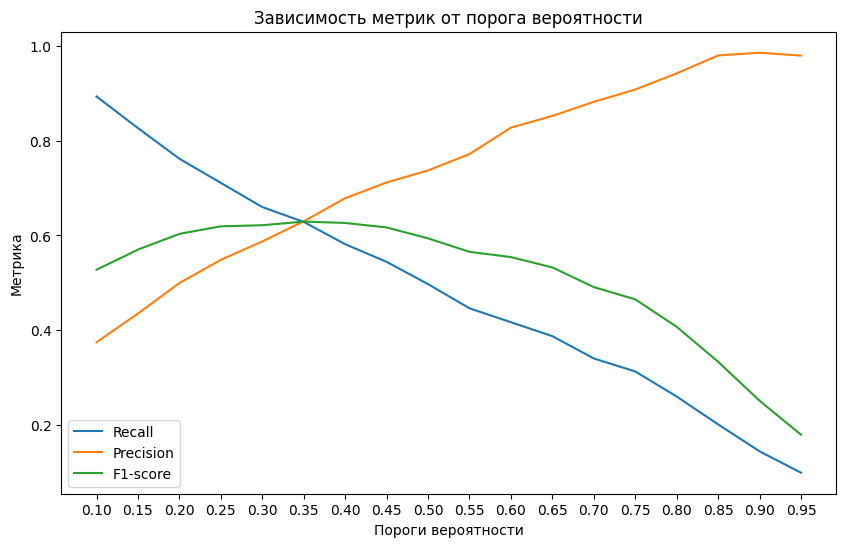

In [116]:
y_preds = threshold_selector(trained_model, X_test, y_test)

На графике определяем точку, которая будет являться оптимальным порогом. Клиентов, для которых вероятность расторгнуть соглашение с банком > 35%, относим к классу 1. В противном случае относим к классу 0 - продолжат сотрудничество. Оптимальной точкой будет точка пересечения трёх метрик.

In [119]:
# Оптимальный порог
threshold = 0.35

In [118]:
# Оценим модель
y_preds = evaluate(trained_model, X_test, y_test, loss_fn)

Функция потерь на тесте: 0.3299638628959656
Recall на тесте: 0.63


Функции потерь на обучающей и тестовой выборках примерно одинаковы. Это говорит о том, что наша модель не переобучается, что хорошо.

##ВЫВОД

In [133]:
display(report_df)

Model  Train_score  Train_time  Valid_score  \
0          LogisticRegression         0.69        0.21         0.68   
1      DecisionTreeClassifier         0.82        0.19         0.80   
2      RandomForestClassifier         0.78       27.25         0.76   
3  GradientBoostingClassifier         1.00        8.81         0.51   

   Valid_time  
0        0.05  
1        0.04  
2        0.41  
3        0.06

Для нагладных результатов проделанной работы используем отчётный датафрейм. Лучшую метрику recall показал алгоритм decision tree: 0.80. На втором месте ансамбль random forest: 0.76. На третьем месте базовая модель - логистическая регрессия: 0.68.

Модель градиентного бустинга слишком быстро переобучается на этих данных. Это происходит потому, что обучение деревьев алгоритма происходит последовательно и эта модель быстро подстраивается под обучающие данные. Алгоритм оказался неэффективен для данной задачи.

Нейросеть была представлена трёхслойным перцептроном. Как показала практика на данной задаче простые модели отработали лучше. Recall полносвязной нейронной сети на этих данных: 0.63

In [136]:
# Обучаем модель на всех обучающих данных
tree_model.fit(X_train, y_train)
tree_model_train = tree_model.predict(X_train)
# Делаем предсказание на тесте
tree_model_pred = tree_model.predict(X_test)

# Оцениваем качество модели по метрике Recall
recall = recall_score(y_test, tree_model_pred)
print(f"Recall на тесте: {recall:.2f}")

Recall на тесте: 0.78


**В итоге конкретно для данной задачи для этих данных выбираем модель Decision Tree** с подобранными гиперпараметрами с помощью GridSearchCV. После обучения, теста и оценки на всех данных мы имеем **recall: 0.78**. Это означает, что модель правильно классифицирует 78% клиентов, которые действительно уходят из банка.